# 08 Model individual oil glands as ellipsoids

Take a plunge into the smallest details

We can approximate individual oil glands as ellipsoids
- Experimental results by [Knight _et al._ (2001)](https://doi.org/10.1006/anbo.2001.1546) and [Voo _et al._ (2012)](https://doi.org/10.1104/pp.112.194233) show that oil glands do indeed are ellipsoidal in shape for navel oranges and grapefruits respectively.
- We use MVEEs, Minimum Volume Enclosing Ellipsoids, in this case.
- The MVEE computation is based on the [Khachiyan algorithm](https://doi.org/10.1016/j.dam.2007.02.013), using a [python implementation](https://github.com/minillinim/ellipsoid)

All the MVEE details are stored as a collection of files as
```
data/oil/<root name>/<label name>/<root name>_<label name>_*.csv
```
See below for more details

<img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/ell_glands_01000.jpg" alt = "barley" style="width:500px;"/>

In [1]:
import numpy as np
import tifffile as tf
import pandas as pd
import glob
import os

from scipy import ndimage
from scipy import spatial

import warnings
warnings.filterwarnings( "ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from importlib import reload

import citrus_utils as vitaminC
from mvee import EllipsoidTool as ET

In [2]:
tissue_src = '../data/tissue/'
oil_dst = '../data/glands/'
oil_src = '../data/oil/'
bnames = [os.path.split(x)[-1] for x in sorted(glob.glob(oil_src + 'WR*'))]
for i in range(len(bnames)):
    print(i, '\t', bnames[i])

0 	 WR05_CRC3605_18B-19-5


In [4]:
bname = bnames[0]
L = 3

lname = 'L{:02d}'.format(L)

src = oil_src + bname + '/' + lname + '/' 
dst = oil_dst + bname + '/' + lname + '/'
filename = src + bname + '_glands.tif'
img = tf.imread(filename)
img[img > 0] = 1
img = img.astype(np.bool)

## Approximate with a MVEE individual oil glands

To speed-up the MVEE computation, we consider only the oil gland voxels that are part of its convex hull.

For each oil gland we collect model information in `N x 3` matrices, where `N` is the number of individual oil glands in the fruit.

- `amvee`: the three sorted semi-axes lengths of the MVEE
- `dmvee`: displacement of the box containing MVEE, that is, the lower left corner of such box
- `rmvee`: rotation matrix of the MVEE (it is a `3N x 3` matrix in this case)
- `cmvee`: center of the MVEE
- `c_mass`: center of mass of the voxel clump that makes up the oil gland

Keep in mind that the center of mass of the gland is not the same as the center of the modeled MVEE, although they are very close to each other.

In [5]:
et = ET()
def MVEE(gland):
    gcoords = np.asarray(np.nonzero(gland))
    c_o_mass = np.mean(gcoords, axis=1)
    hull = spatial.ConvexHull(gcoords.T)
    phull = hull.points[hull.vertices]
    origin, radii, rotation = et.getMinVolEllipse(phull, 1e-2)
    return origin, radii, rotation, c_o_mass

In [7]:
filename = src + bname + '_' + lname + '_cmvee.csv'

if os.path.isfile(filename):
    cmvee = np.loadtxt(filename, delimiter=',')
    
    filename = src + bname + '_' + lname + '_amvee.csv'
    amvee = np.loadtxt(filename, delimiter=',')

    filename = src + bname + '_' + lname + '_dmvee.csv'
    dmvee = np.loadtxt(filename, delimiter=',')

    filename = src + bname + '_' + lname + '_rmvee.csv'
    rmvee = np.loadtxt(filename, delimiter=',')
    
    filename = src + bname + '_' + lname + '_glands.csv'
    c_mass = np.loadtxt(filename, delimiter=',')
    print('Loaded', filename)
    
else:
    struc = ndimage.generate_binary_structure(img.ndim, 1)
    labels, nums = ndimage.label(img, structure=struc)
    slices = ndimage.find_objects(labels)
    
    cmvee = np.zeros((nums, img.ndim))
    amvee = np.zeros_like(cmvee)
    dmvee = np.zeros_like(cmvee)
    c_o_mass = np.zeros_like(cmvee)
    rmvee = np.zeros((3*nums, img.ndim))
    
    for i in range(nums):
        gland = img[slices[i]].copy()
        mask = labels[slices[i]] == i+1
        gland[~mask] = False
        cmvee[i], amvee[i], rmvee[3*i:3*i+3], c_o_mass[i] = MVEE(gland)
        for j in range(img.ndim):
            dmvee[i,j] = slices[i][j].start
    
    filename = src + bname + '_' + lname + '_cmvee.csv'
    np.savetxt(filename, cmvee, fmt='%.10f', delimiter=',')

    filename = src + bname + '_' + lname + '_amvee.csv'
    np.savetxt(filename, amvee, fmt='%.10f', delimiter=',')

    filename = src + bname + '_' + lname + '_dmvee.csv'
    np.savetxt(filename, dmvee, fmt='%.10f', delimiter=',')

    filename = src + bname + '_' + lname + '_rmvee.csv'
    np.savetxt(filename, rmvee, fmt='%.10f', delimiter=',')
    
    c_mass = c_o_mass + dmvee
    filename = src + bname + '_' + lname + '_glands.csv'
    np.savetxt(filename, c_mass, fmt='%.10f', delimiter=',')
    print('Saved ', filename)

img = False
labels = False
slices = False

Saved  ../data/oil/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_L03_glands.csv


In [9]:
centers = (cmvee + dmvee).copy()

### Plot the first 30 oil glands

The 3D plot in matplotlib is always funky

Plotted ../data/glands/WR05_CRC3605_18B-19-5/L03/ell_glands_00000.jpg


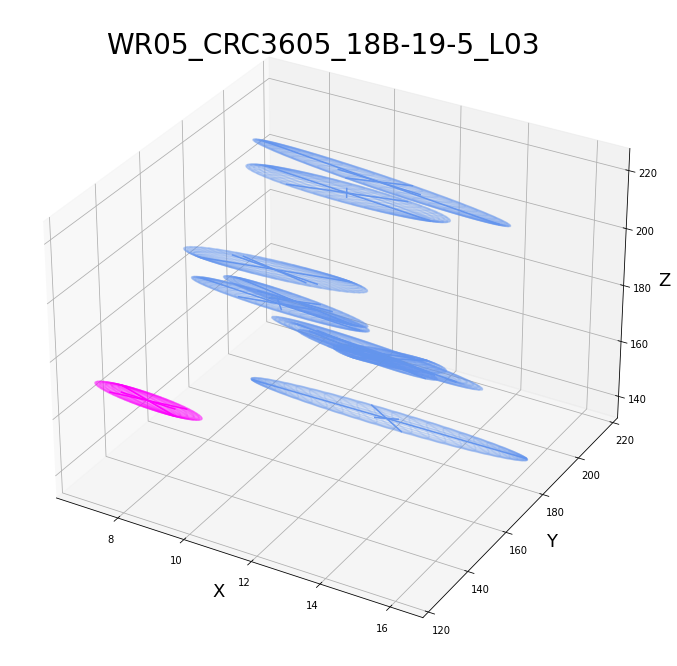

In [16]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
fs = 18
#lim = np.max(gland.shape)
#ax.set_xlim(240,275);ax.set_ylim(225, 260);ax.set_zlim(135, 170)

idx = 0

ax.set_xlabel('X', fontsize=fs); ax.set_ylabel('Y', fontsize=fs); ax.set_zlabel('Z', fontsize=fs)
for i in range(idx+1,idx+10):
    et.plotEllipsoid(centers[i], amvee[i], rmvee[3*i:3*i+3], ax=ax, cageColor='cornflowerblue', 
                     plotAxes=True, cageAlpha=0.2)

et.plotEllipsoid(centers[idx], amvee[idx], rmvee[3*idx:3*idx+3], ax=ax, plotAxes=True, cageColor='magenta')
fig.suptitle(bname + '_' + lname, fontsize=fs+10, y=0.85)

filename = dst + 'ell_glands_{:05d}.jpg'.format(idx)
#plt.savefig(filename,format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True},dpi=96)
print('Plotted', filename)

# References

- **Knight, TG**, **Klieber, A**, **Sedgley, M** (2001) The Relationship Between Oil Gland and Fruit Development in Washington Navel Orange (_Citrus sinensis_ L. Osbeck). _Annals of Botany_ **88**(6), 1039-1047. [DOI: 10.1006/anbo.2001.1546](https://doi.org/10.1006/anbo.2001.1546)

- **Todd, MJ**, **Yıldırım, EA** (2007) On Khachiyan's algorithm for the computation of minimum-volume enclosing ellipsoids. _Discrete Applied Mathematics_ **155**(13), 1731-1744. [DOI: 10.1016/j.dam.2007.02.013](https://doi.org/10.1016/j.dam.2007.02.013)

- **Voo, SS**, **Grimes, HD**, **Lange, BM** (2012) Assessing the biosynthetic capabilities of secretory glands in Citrus peel. _Plant physiology_ **159**(1), 81-94. [DOI: 10.1104/pp.112.194233](https://doi.org/10.1104/pp.112.194233)